# Air pressure System failure in Scania Trucks

## 1 - Business Problem

### 1.1 - Description

1. Scania is a major Swedish manufacturer, which specialises in
manufacturing heavy commercial trucks, a truck is made up of lots of
components, one such very important component in a truck, is the
braking system of truck, proper functioning of braking system is very
important otherwise it may lead to to several issues, including accident
in the worst case. The braking system of a truck works on an air
pressure system which requires pressurized air to operate if the air
pressure falls below a certain threshold then the brakes won't work
properly.
2. So it's very important for the air pressure system of trucks to work
properly.
3. Now the problem that Scania is facing is that to check, air pressure
system of each and every truck manually by a mechanic, is a time
consuming and costly process.
4. So they want to automate this process using a predictive model to
build the predictive model they provided US data based on everyday
uses of scania trucks

### 1.2 Why this problem is important

If we are able to detect failue in aAPS before actual occurance of failure then we can reduce lot of manual effort,time,and money which goes into checking of APS at workshop
also in some scenariors APS failue can lead to accident that;s why predictive maintainence is very important

### 1.2 - Business objectives and constraints

1 - Our task is to build a predictive model which can predict as accurately or as possible that whether failure in the 
truck has anything to do with the air pressure system of the truck or not.                                                 
2 - Cost of missing a filed truck is very very high as well as predicting a non faulty truck as faulty is also not desirable.          
3 - There is not very low latency constraint.                                                                             
4 - It's beneficial to have a model which along with good perfonce is also interpretable.

## 2 - Understanding the data

1 - Data source - https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set?select=aps_failure_training_set.csv                                       
2 - Data is given in the form of two csv files which are aps_failure_training_set.csv and aps_failure_test_set.csv                                       
3 - Size of aps_failure_training_set.csv is 43 MB and there are 60,000 rows in this file and there are 171 features including the class labels,
    the name of the features is not given due to proprietary reasons.                                                         
4 - There are two class labels pos and neg, pos means means failure was due to APS and neg means  that failure has nothing 
    to do with APS                                                                                                           
5 - Size of aps_failure_test_set.csv is 11 MB and there are 16,000 rows in this file and there are 171 features including 
    the class labels.                                                                                                       
6 - Missing values are denoted by "na"

## 3 - Mapping Business Problem to a Machine learning problem

### 3.1 - Type of ML Problem

We can model this problem ststement as a binary classification problem

### 3.2 - Performence Metric

1 - Macro f1 score - its the average f1 score for pos and neg class   
2 - Total Cost = 10*FP + FN*500                                                                                          
    Here FN is false negative and FP is false Positive                                                                      
    We are giving high penality for FN as compared to FP because as we dissued above cost of FN is very high                                                          
3 - Binary confusion matrix - This will help us in understing FP and FN for every model that we will train later

### 3.3 - Splitting data for Training, Cross Validation and Testing

1 - From the ida_2016_training_set_update.csv(traing dataset) we will use 20% od points for cross validation and rest of data
    for training the model.                                                                                                  
2 - For testing we will use ida_2016_test_set_update.csv as it is.

# 4 - Exploritory Data Analysis

### 4.1 - Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import plotly.offline as offline
import plotly.graph_objs as go
import joblib
from sklearn.metrics import f1_score
import math
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
import prettytable

### 4.2 - Redaing Training and Test data

In [2]:
train_df = pd.read_csv("aps_failure_training_set.csv")
test_df = pd.read_csv("aps_failure_test_set.csv")
row_train,col_train = train_df.shape
row_test,col_test = test_df.shape
print("Number of rows in training data is ",row_train,"and number of columns are ",col_train)
print("Number of rows in test data is ",row_test,"and number of columns are ",col_test)

Number of rows in training data is  60000 and number of columns are  171
Number of rows in test data is  16000 and number of columns are  171


### 4.3 - Analysing data and doing some simple data cleaning 

In [3]:
# viewing fiest two rows of traing data
train_df.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0


In [4]:
# viewing fiest two rows of test data
test_df.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0


### Observation

we can se that class labels are pos and neg and there are missing values denoted as na                                       
so we can replace pos with 1 and neg as 0, we will reoplace "na" by np.nan                                                     
now in test data id feature is useless so we will remove it 

In [5]:
train_df["class"] = train_df["class"].replace("pos",1)
train_df["class"] = train_df["class"].replace("neg",0)

test_df["class"] = test_df["class"].replace("pos",1)
test_df["class"] = test_df["class"].replace("neg",0)

train_df = train_df.replace({"na":np.nan})
test_df = test_df.replace({"na":np.nan})

In [6]:
train_df.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0


In [7]:
test_df.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,0,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0


### 4.4 = Distribution of class labels

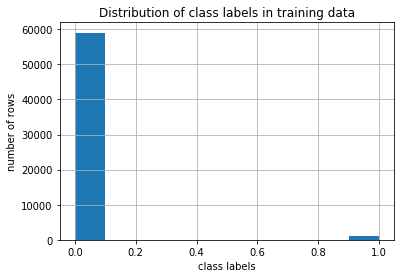

count of pos and neg data points are  0    59000
1     1000
Name: class, dtype: int64


In [8]:
train_df["class"].hist()
plt.xlabel("class labels")
plt.ylabel("number of rows")
plt.title("Distribution of class labels in training data")
plt.show()
print("count of pos and neg data points are ",train_df["class"].value_counts())

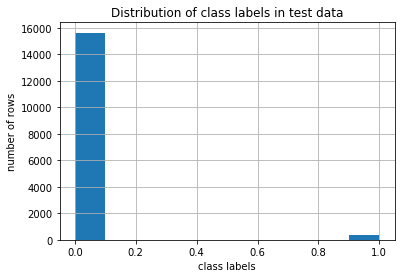

count of pos and neg data points are  0    15625
1      375
Name: class, dtype: int64


In [9]:
test_df["class"].hist()
plt.xlabel("class labels")
plt.ylabel("number of rows")
plt.title("Distribution of class labels in test data")
plt.show()
print("count of pos and neg data points are ",test_df["class"].value_counts())

### Observation
1 - there are 59,000 points belomging to class 0 and 1000 points belonging to class 0 in training data                        
2 -  there are 15625 points belomging to class 0 and 375 points belonging to class 0 in test data                           
3 - Data is highly imbalanced.

### 4.4 - Spliting data into train and cross validation

Before doing futher analusis let's split the data and store in csv file after cleaning

In [10]:
# we are using strstied sampling because data is highly imbalanve and we same distribution of class labels in train and cv data
train,cv = train_test_split(train_df,test_size=0.2,random_state=1,stratify=train_df["class"])

# train.to_csv("train.csv",index=False)
# cv.to_csv("cv.csv",index=False)
# test_df.to_csv("test.csv",index=False)

reading the training data

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,240432,2.0,700.0,NaN,0.0,0.0,0.0,0.0,0.0,...,1351496.0,572640.0,1016878.0,939842.0,1590258.0,4725574.0,84676.0,8.0,0.0,0.0
1,0,820,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,2756.0,1270.0,5414.0,4380.0,7066.0,14060.0,0.0,0.0,0.0,0.0


### 4.5 - Checking Missing Values

In [3]:
# ckeck if any missing value is present
train_df.isnull().values.any()

True

There are missing values in data
so now we need to check how many missing values are present in data

In [4]:
column = np.array(train_df.columns[1:]) # store all column in a list
missing = np.array(48000 - train_df.count()) # count mumber of missing values for each attribue total rows is 48,000
missing = missing[1:]
missing = missing/480
#print(missing)

In [5]:
max = np.max(missing) # find max value for number of missing value
max_index = np.argmax(missing)# find index for number of missing value
max_col = column[max_index]# find colum name for number of missing value

min = np.min(missing)
min_index = np.argmin(missing)
min_col = column[min_index + 1]

print("column",min_col,"has no missing value while column",max_col,"has highest missing value which is ",missing[max_index],"%")

column ab_000 has no missing value while column br_000 has highest missing value which is  82.14375 %


In [6]:
# seperating columns based on prcentage of missing values
miss_10 = []
miss_10_70 = []
miss_70 = []
for i in range(len(missing)):
    if missing[i] <= 10:
        miss_10.append(i)
    elif missing[i] > 10 and missing[i] < 70:
        miss_10_70.append(i)
    else:
        miss_70.append(i)

miss_column_70 = column[miss_70]
miss_column_10 = column[miss_10]
miss_column_10_70 = column[miss_10_70]
print("columns for which missing values are more than 70%\n")

for i in range(len(miss_70)):
    print("for column",miss_column_70[i],"percentage of missing values are",missing[miss_70[i]],"%")

columns for which missing values are more than 70%

for column ab_000 percentage of missing values are 77.125 %
for column bn_000 percentage of missing values are 73.28958333333334 %
for column bo_000 percentage of missing values are 77.25416666666666 %
for column bp_000 percentage of missing values are 79.58958333333334 %
for column bq_000 percentage of missing values are 81.23541666666667 %
for column br_000 percentage of missing values are 82.14375 %
for column cr_000 percentage of missing values are 77.125 %


In [7]:
# for those columns where more than 70% values are missing we are filling it with -10000000 for further analysis
missing_df_70 = train_df[miss_column_70]
missing_df_70.fillna(-1000000,inplace=True)
missing_df_70.head()

,ab_000,bn_000,bo_000,bp_000,bq_000,br_000,cr_000
0,2.0,125540.0,128000.0,148940.0,135020.0,144840.0,0.0
1,0.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,0.0
2,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
3,0.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,0.0
4,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0


In [8]:
miss_counts = []
for i in miss_column_70:
    temp_df = missing_df_70[[i]]
    temp_df["class"] = train_df["class"]
    temp_df = temp_df.loc[temp_df[i] == -1000000]
    miss_counts.append(np.array(temp_df["class"].value_counts()))

In [9]:
count_class = np.array(train_df["class"].value_counts())
for i in range(len(miss_counts)):
    print("for those rows where column",miss_column_70[i], "is missing no of rows belong to class 1 are",miss_counts[i][1],"and class 0 are",miss_counts[i][0])

print("total no of points belonging to class 1 and class 0 are",count_class[0],"and",count_class[1],"respectively")

for those rows where column ab_000 is missing no of rows belong to class 1 are 614 and class 0 are 36406
for those rows where column bn_000 is missing no of rows belong to class 1 are 56 and class 0 are 35123
for those rows where column bo_000 is missing no of rows belong to class 1 are 58 and class 0 are 37024
for those rows where column bp_000 is missing no of rows belong to class 1 are 63 and class 0 are 38140
for those rows where column bq_000 is missing no of rows belong to class 1 are 67 and class 0 are 38926
for those rows where column br_000 is missing no of rows belong to class 1 are 70 and class 0 are 39359
for those rows where column cr_000 is missing no of rows belong to class 1 are 614 and class 0 are 36406
total no of points belonging to class 1 and class 0 are 47200 and 800 respectively


we can see that for column ab_000 and cr_000 points beloging to positive class are 614 among 800 positive points so we will 
keep this feature and discard all other feature where no of missing value are mote than 70%
while keeping this feature we will keep the feature name as it is and replace missing value with 1 and rest of all the values with 0

In [10]:
# create a data frame to store these faetures
temp1 = np.array(missing_df_70["ab_000"])
temp2 = np.array(missing_df_70["cr_000"])
temp1 = np.where((temp1 == -1000000),1,0)
temp2 = np.where((temp2 == -1000000),1,0)

df_70 = pd.DataFrame(list(zip(temp1,temp2)),columns=["ab_000","cr_000"])

For those columns where no of missing values are less than 10% we are imputing with median and for missing values between 10% to 70%
we are using KNN based imputation

In [ ]:
#replace values in those columns which have missing value less than 10% by median value for corresponding feature
df_10 = train_df[miss_column_10]
df_10_70 = train_df[miss_column_10_70]

df_10.fillna(df_10.median(),inplace=True)

# replace values in those columns which have missing value between 10% and 70% by knn inputaion using fit_transform
imputer = KNNImputer(n_neighbors=2)
df_10_70 = pd.DataFrame(imputer.fit_transform(df_10_70))
df_10_70.columns = miss_column_10_70

train_cleaned = pd.concat([df_10,df_10_70,df_70],axis=1)
train_cleaned["class"] = train_df["class"]

In [ ]:
# store data in csv file after filling missing values
#train_cleaned.to_csv("clean_train.csv",index=False)

In [15]:
# # save imputer to disk
# knn_imputer = "knn_imputer.pkl"
# joblib.dump(imputer,knn_imputer)

# knn_imputer = "knn_imputer.pkl"
# new_imputer = joblib.load(knn_imputer)

Cleaning CV Data

In [23]:
#code reference https://stackoverflow.com/questions/21608228/conditional-replace-pandas
# Cleaning those columns which have missing value more than 70%

cv_df = pd.read_csv("cv.csv")#bn_000

cv_df = cv_df.drop(["bn_000","bo_000","bp_000","bq_000","br_000"],axis=1)

cv_df[["ab_000","cr_000"]] = cv_df[["ab_000","cr_000"]].fillna(1)

cv_df.loc[cv_df["ab_000"] != 1, "ab_000"] = 0
cv_df.loc[cv_df["cr_000"] != 1, "cr_000"] = 0

cv_df_70 = cv_df[["ab_000","cr_000"]]

In [ ]:
# save median of train data which we will use to replace null values in test and cv data
# train_df[miss_column_10].median().to_csv("median.csv",index=False)
# median = pd.read_csv("median.csv")

In [24]:
#cv_df[miss_column_10] = cv_df[miss_column_10].fillna(median["0"].median())
#replace values in those columns which have missing value less than 10% by median value of train data for corresponding feature
    
cv_df[miss_column_10] = cv_df[miss_column_10].fillna(train_df[miss_column_10].median())
cv_df[miss_column_10].isnull().values.any()

cv_df_10 = cv_df[miss_column_10]

False

In [26]:
# replace values in those columns which have missing value between 10% and 70% by knn inputaion using fit_transform
cv_df_10_70 = pd.DataFrame(new_imputer.transform(cv_df[miss_column_10_70]))
cv_df_10_70.columns = miss_column_10_70
cv_df_10_70.isnull().values.any()

False

In [33]:
# combine all the columns
cv_cleaned = pd.concat([cv_df_10,cv_df_10_70,cv_df_70],axis=1)
# adding clas labels
cv_cleaned["class"] = cv_df["class"]

In [35]:
# store cv_data in csv file after filling missing values
#cv_cleaned.to_csv("clean_cv.csv",index=False)

Cleaning Test Data

In [13]:
#code reference https://stackoverflow.com/questions/21608228/conditional-replace-pandas

# Cleaning those columns which have missing value more than 70%
test_df = pd.read_csv("test.csv")#bn_000

test_df = test_df.drop(["bn_000","bo_000","bp_000","bq_000","br_000"],axis=1)# drop these columns

test_df[["ab_000","cr_000"]] = test_df[["ab_000","cr_000"]].fillna(1) # fill nan values with 1

test_df.loc[test_df["ab_000"] != 1, "ab_000"] = 0# fill everything except 1 with zero
test_df.loc[test_df["cr_000"] != 1, "cr_000"] = 0

test_df_70 = test_df[["ab_000","cr_000"]]

In [14]:
#cv_df[miss_column_10] = cv_df[miss_column_10].fillna(median["0"].median())

# replace values in those columns which have missing value less than 10% by median value of train data for corresponding feature
test_df[miss_column_10] = test_df[miss_column_10].fillna(train_df[miss_column_10].median())
test_df[miss_column_10].isnull().values.any()

test_df_10 = test_df[miss_column_10]

In [16]:
# replace values in those columns which have missing value between 10% and 70% by knn inputaion using fit_transform
test_df_10_70 = pd.DataFrame(new_imputer.transform(test_df[miss_column_10_70]))
test_df_10_70.columns = miss_column_10_70
test_df_10_70.isnull().values.any()

False

In [17]:
# combine all the columns
test_cleaned = pd.concat([test_df_10,test_df_10_70,test_df_70],axis=1)
# adding clas labels
test_cleaned["class"] = test_df["class"]

In [18]:
# store cv_data in csv file after filling missing values
test_cleaned.to_csv("clean_test.csv",index=False)

### 4.6 - Checking for duplicates

In [ ]:
# ckeck if any duplicate value is present
train_df.duplicated().values.any()

There are no duplicate values in data

### 4.7 Univariate Analysis

let's load the datset after imputing missing values

In [23]:
train_df = pd.read_csv("clean_train.csv")
train_df.head(2)

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,...,cy_000,cz_000,da_000,db_000,dc_000,ec_00,ed_000,ab_000,cr_000,class
0,240432,700.0,0.0,0.0,0.0,0.0,0.0,526538.0,4349060.0,6196126.0,...,0.0,8822.0,0.0,0.0,10183782.0,4126.58,4986.0,0,0,0
1,820,20.0,0.0,0.0,0.0,0.0,0.0,0.0,45186.0,10624.0,...,0.0,54.0,0.0,0.0,44888.0,187.92,132.0,0,0,0


since there are 170 fetures and analysing all these features is not feasible so we will train a decesion tree and take top 10 features in order to do data analysis

In [24]:
target = train_df["class"]
train_df = train_df.drop(["class"],axis=1)

train_df.isnull().values.any()

False

In [27]:
clf = DecisionTreeClassifier(max_depth=6,splitter="best")
clf.fit(train_df,target)

feat_imp = clf.feature_importances_

imp_col_10 = np.argpartition(feat_imp,-10)[-10:]
imp_col_5 = np.argpartition(feat_imp,-5)[-5:]

columns = np.array(train_df.columns)

train_df_10 = train_df[columns[imp_col_10]]
train_df_5 = train_df[columns[imp_col_5]]

train_df_10["class"] = target
train_df_5["class"] = target

train_df_10.head(2)

,bi_000,ay_002,cc_000,ay_006,ay_008,ag_001,ag_002,al_000,ay_005,bj_000,class
0,741016.0,0.0,13403012.0,26154.0,11391860.0,0.0,0.0,337652.0,2488.0,936496.0,0
1,11320.0,0.0,60094.0,0.0,14276.0,0.0,0.0,980.0,0.0,8702.0,0


In [28]:
train_df_10.columns

Index(['bi_000', 'ay_002', 'cc_000', 'ay_006', 'ay_008', 'ag_001', 'ag_002',
       'al_000', 'ay_005', 'bj_000', 'class'],
      dtype='object')

We will plot violin and boxplots for all the 10 features which we have slcted

defining some functions which we will use for analysis

In [29]:
def box_violin(name,df):
    """
    this function takes name of column as input and plots boxplot and violin plot groped by class label
    """
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1,2,1)
    sns.violinplot(x=train_df_10["class"],y=df[name])
    plt.title("Violinplot for column " + name )
    
    plt.subplot(1,2,2)
    sns.boxplot(x=train_df_10["class"],y=df[name])
    plt.title("Boxplot for column " + name)
    plt.show()

#### 4.7.1 - Analysing bi_000 using boxplot violinplot

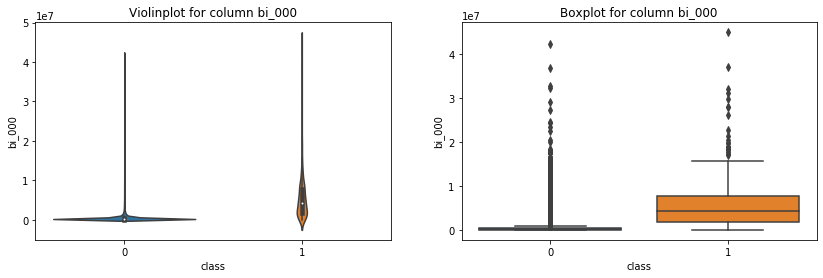

In [30]:
box_violin("bi_000",train_df_10)

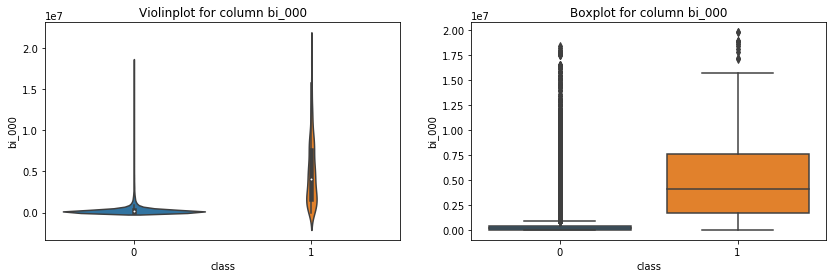

In [31]:
#remove those points which have value more than 1*(10**7) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["bi_000"] < 2*(10**7)]
box_violin("bi_000",temp1)

### Obseravtions
1 - for neg class 0th to 75th percentile values are zero                                                                 
2 - for pos class 0th to 50th percentile values are zero                                                                   
3 - those points which have value more than 0 are more likely to belong to pos class

#### 4.7.2 - Analysing ay_002 using boxplot violinplot

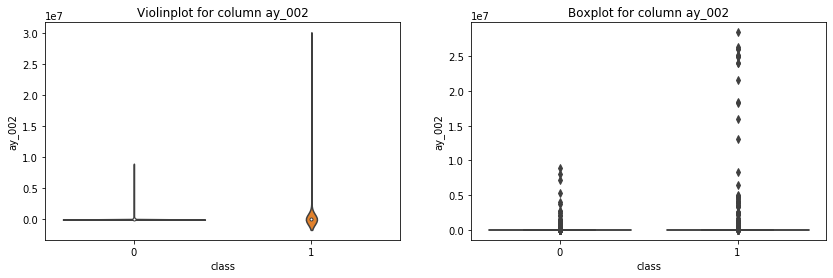

In [32]:
box_violin("ay_002",train_df_10)

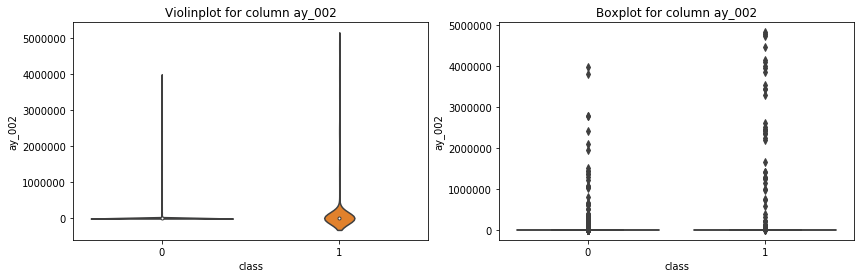

In [33]:
#remove those points which have value more than 0.5*(10**7) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["ay_002"] < 0.5*(10**7)]
box_violin("ay_002",temp1)

### Obseravtions
1 - for neg class 0th to 75th percentile values are zero                                                         
2 - for pos class 0th to 75th percentile values are zero                                                                  
3 - There is not much clear seperability between pos and neg classes but                                                     
4 - those points which have more than 10**7 belongs pos class

#### 4.7.3 - Analysing al_000 using boxplot violinplot

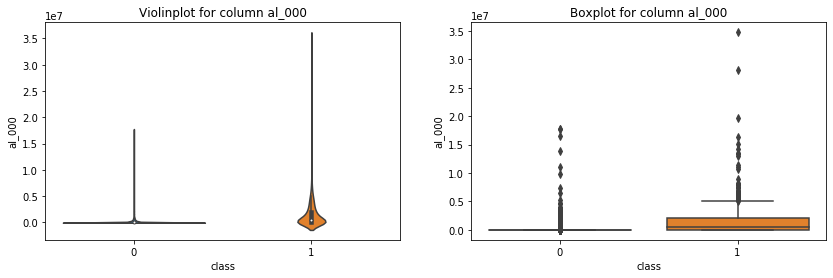

In [34]:
box_violin("al_000",train_df_10)

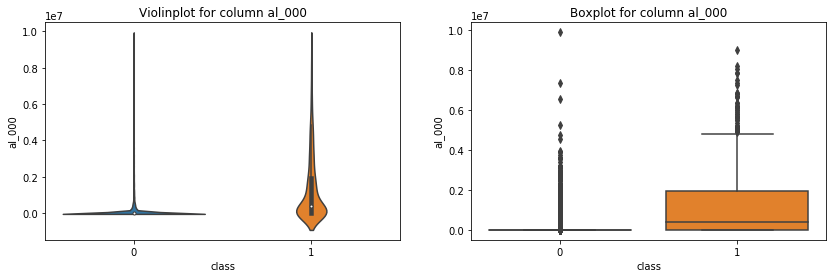

In [35]:
#remove those points which have value more than 1*(10**7) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["al_000"] < 1*(10**7)]
box_violin("al_000",temp1)

### Obseravtions
1 - for neg class oth to 75th percentile values are zero                                                               
2 - for pos class oth to 50th percentile values are zero                                                                 
3 - those points which have value more than 2*10**7 belongs pos class                                                        
4 - those points which have more than 0.1*10**7 belongs pos class

#### 4.7.4 - Analysing bj_000 using boxplot violinplot

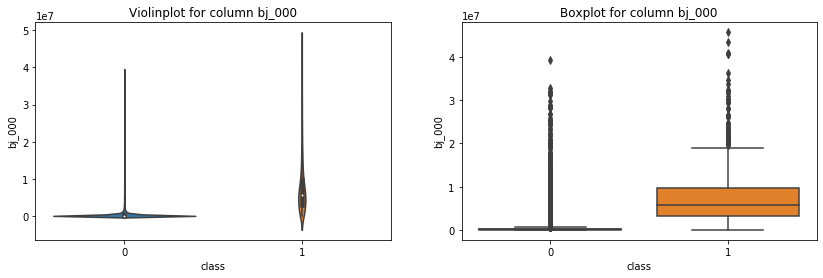

In [36]:
box_violin("bj_000",train_df_10)

### Obseravtions
1 - for neg class oth to 75th percentile most of the values are zero                                                    
2 - those points which have value more than 4*10**7 belongs pos class                                                  
3 - those points which have value more than 0 are vely likely belongs to pos class                                                  

#### 4.7.5 - Analysing ag_002 using boxplot violinplot

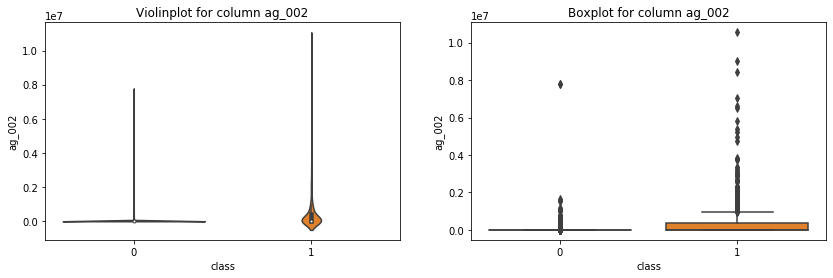

In [37]:
box_violin("ag_002",train_df_10)

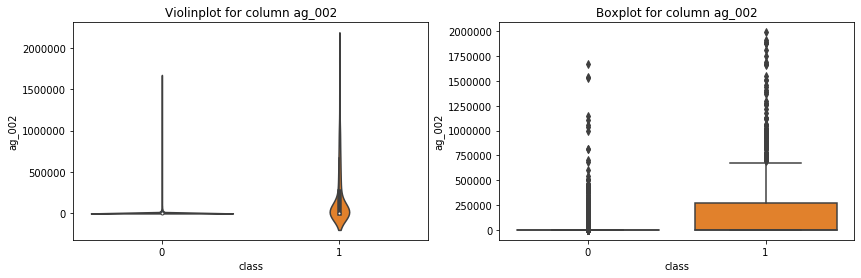

In [38]:
#remove those points which have value more than 0.2*(10**7) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["ag_002"] < 0.2*(10**7)]
box_violin("ag_002",temp1)

### Obseravtions
1 - for neg class 0th to 75th percentile values are zero                                                  
2 - those points which have value more than 0 are most likely belongs to pos class

#### 4.7.6 - Analysing ag_001 using boxplot violinplot

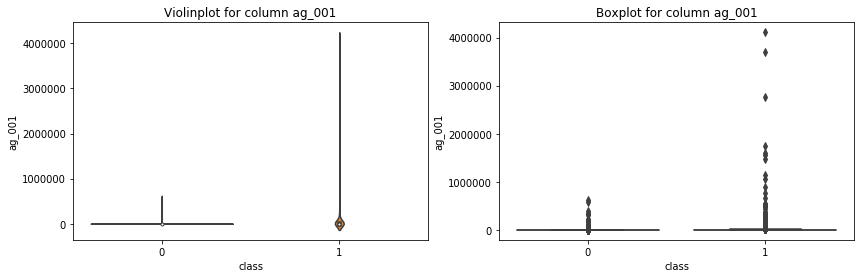

In [39]:
box_violin("ag_001",train_df_10)

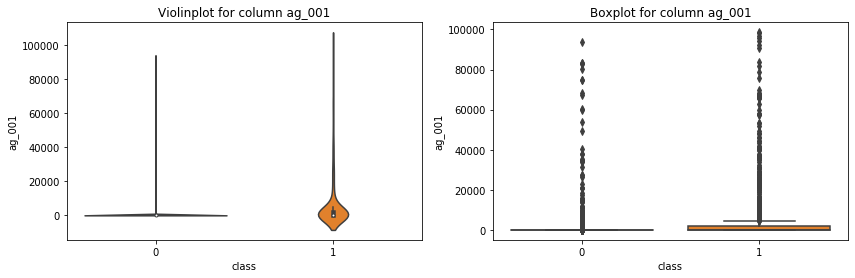

In [40]:
#remove those points which have value more than 0.01*(10**7) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["ag_001"] < 0.01*(10**7)]
box_violin("ag_001",temp1)

### Obseravtions
1 - for neg class oth to 75th percentile values are zero                                                  
2 - those points which have value more than 0.8*10**7 belongs pos class                                                  
3 - there is not much seperability between pos and neg class                                                  

#### 4.7.7 - Analysing ay_006 using boxplot violinplot

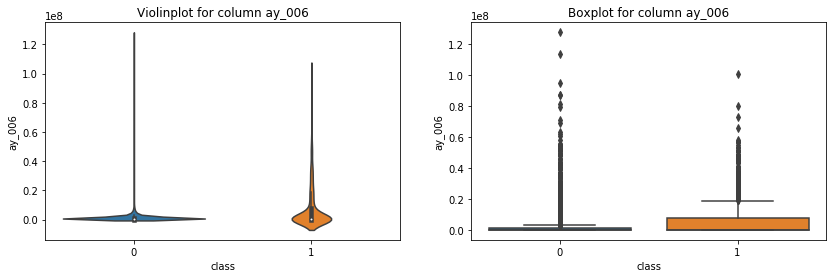

In [41]:
box_violin("ay_006",train_df_10)

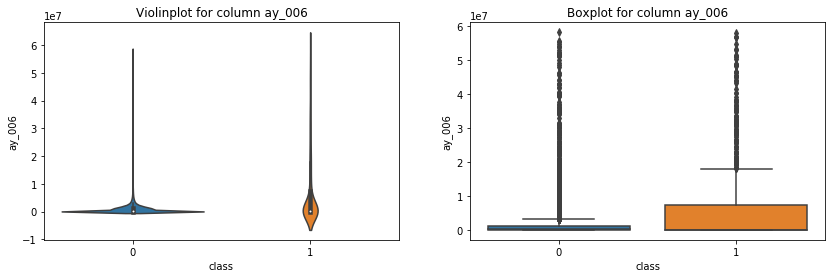

In [42]:
#remove those points which have value more than 0.6*(10**8) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["ay_006"] < 0.6*(10**8)]
box_violin("ay_006",temp1)

### Obseravtions
1 - for neg class 0th to 75th percentile most of the values are close to zero                                                  
2 - those points which have value more than 1*10**7 belongs neg class                                                  

#### 4.7.8 - Analysing ay_005 using boxplot violinplot

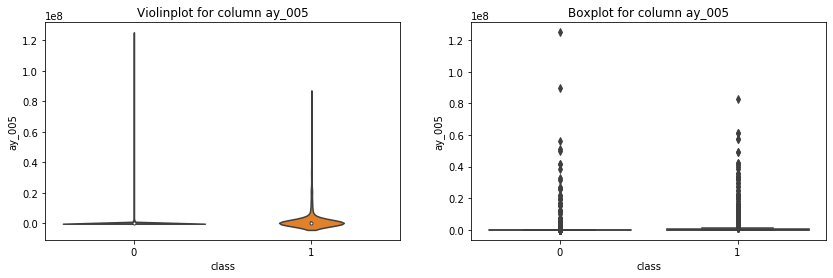

In [43]:
box_violin("ay_005",train_df_10)

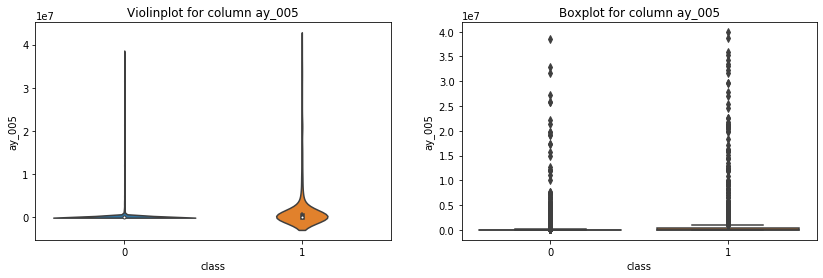

In [44]:
#remove those points which have value more than 0.4*(10**8) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["ay_005"] < 0.4*(10**8)]
box_violin("ay_005",temp1)

### Obseravtions
1 - for neg class between 0th to 75th percentile most of the values are close to zero                                           
2 - for pos class also between 0th to 75th percentile most of the values are close to zero                                      
3 - there is no clear seperation between pos and neg class

#### 4.7.9 - Analysing cc_000 using boxplot violinplot

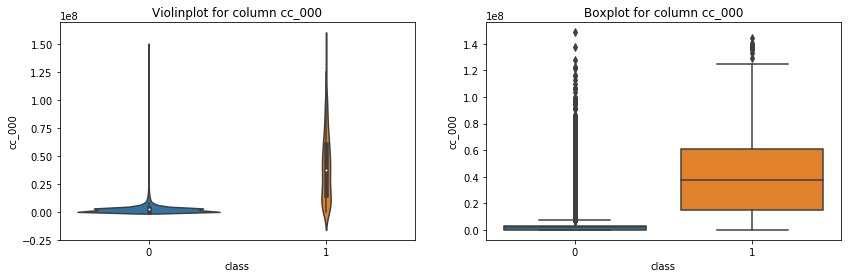

In [45]:
box_violin("cc_000",train_df_10)

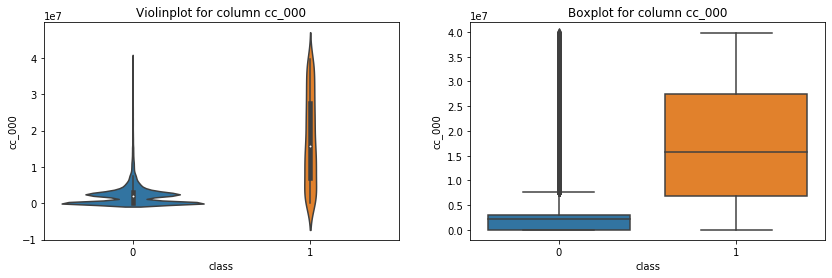

In [46]:
#remove those points which have value more than 0.4*(10**8) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["cc_000"] < 0.4*(10**8)]
box_violin("cc_000",temp1)

### Obseravtions
1 - for neg class 0th to 75th percentile most of the values are zero                                                     
2 - those points which have value more than 0.1*10**7 are vely likely belongs to pos class

#### 4.7.10 - Analysing ay_008 using boxplot

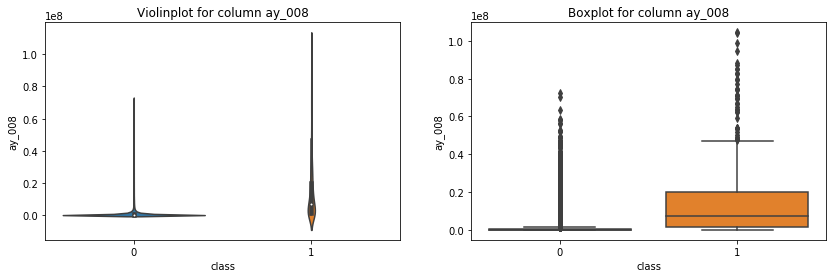

In [47]:
box_violin("ay_008",train_df_10)

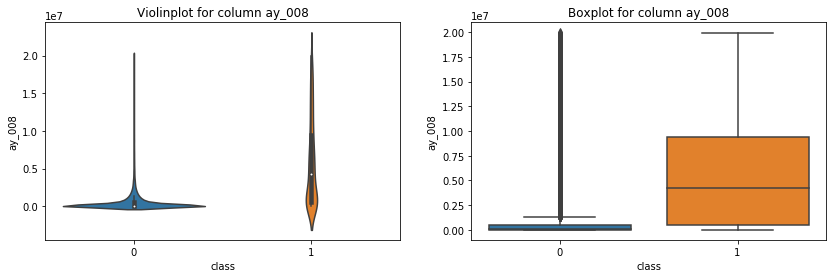

In [48]:
#remove those points which have value more than 0.2*(10**8) for this feature so as to analyse boxplot better
temp1 = train_df_10.loc[train_df_10["ay_008"] < 0.2*(10**8)]
box_violin("ay_008",temp1)

### Obseravtions
1 - for neg class oth to 75th percentile most of the values are zero                                                  
2 - those points which have value more than 0.7*10**7 belongs pos class                                                  
3 - those points which have value more than 0.25*10**7 are very likely belongs to pos class

### 4.8  Observation and Conclusions from univariate analysis

1 - There are lots of values in all the features which are higher than median so these can be ouliers.                                                                                                                  
2 - All the features have some overlap between positive and neg labels                                                       
3 - features like ay_008,cc_000 and bj_000 are more helping in seperting pos from neg class since these have least overlap between pos and neg labels

### 4.9 Bivariate Analysis

For bivariate analysis we will use pair plots for 5 important features that we got above.

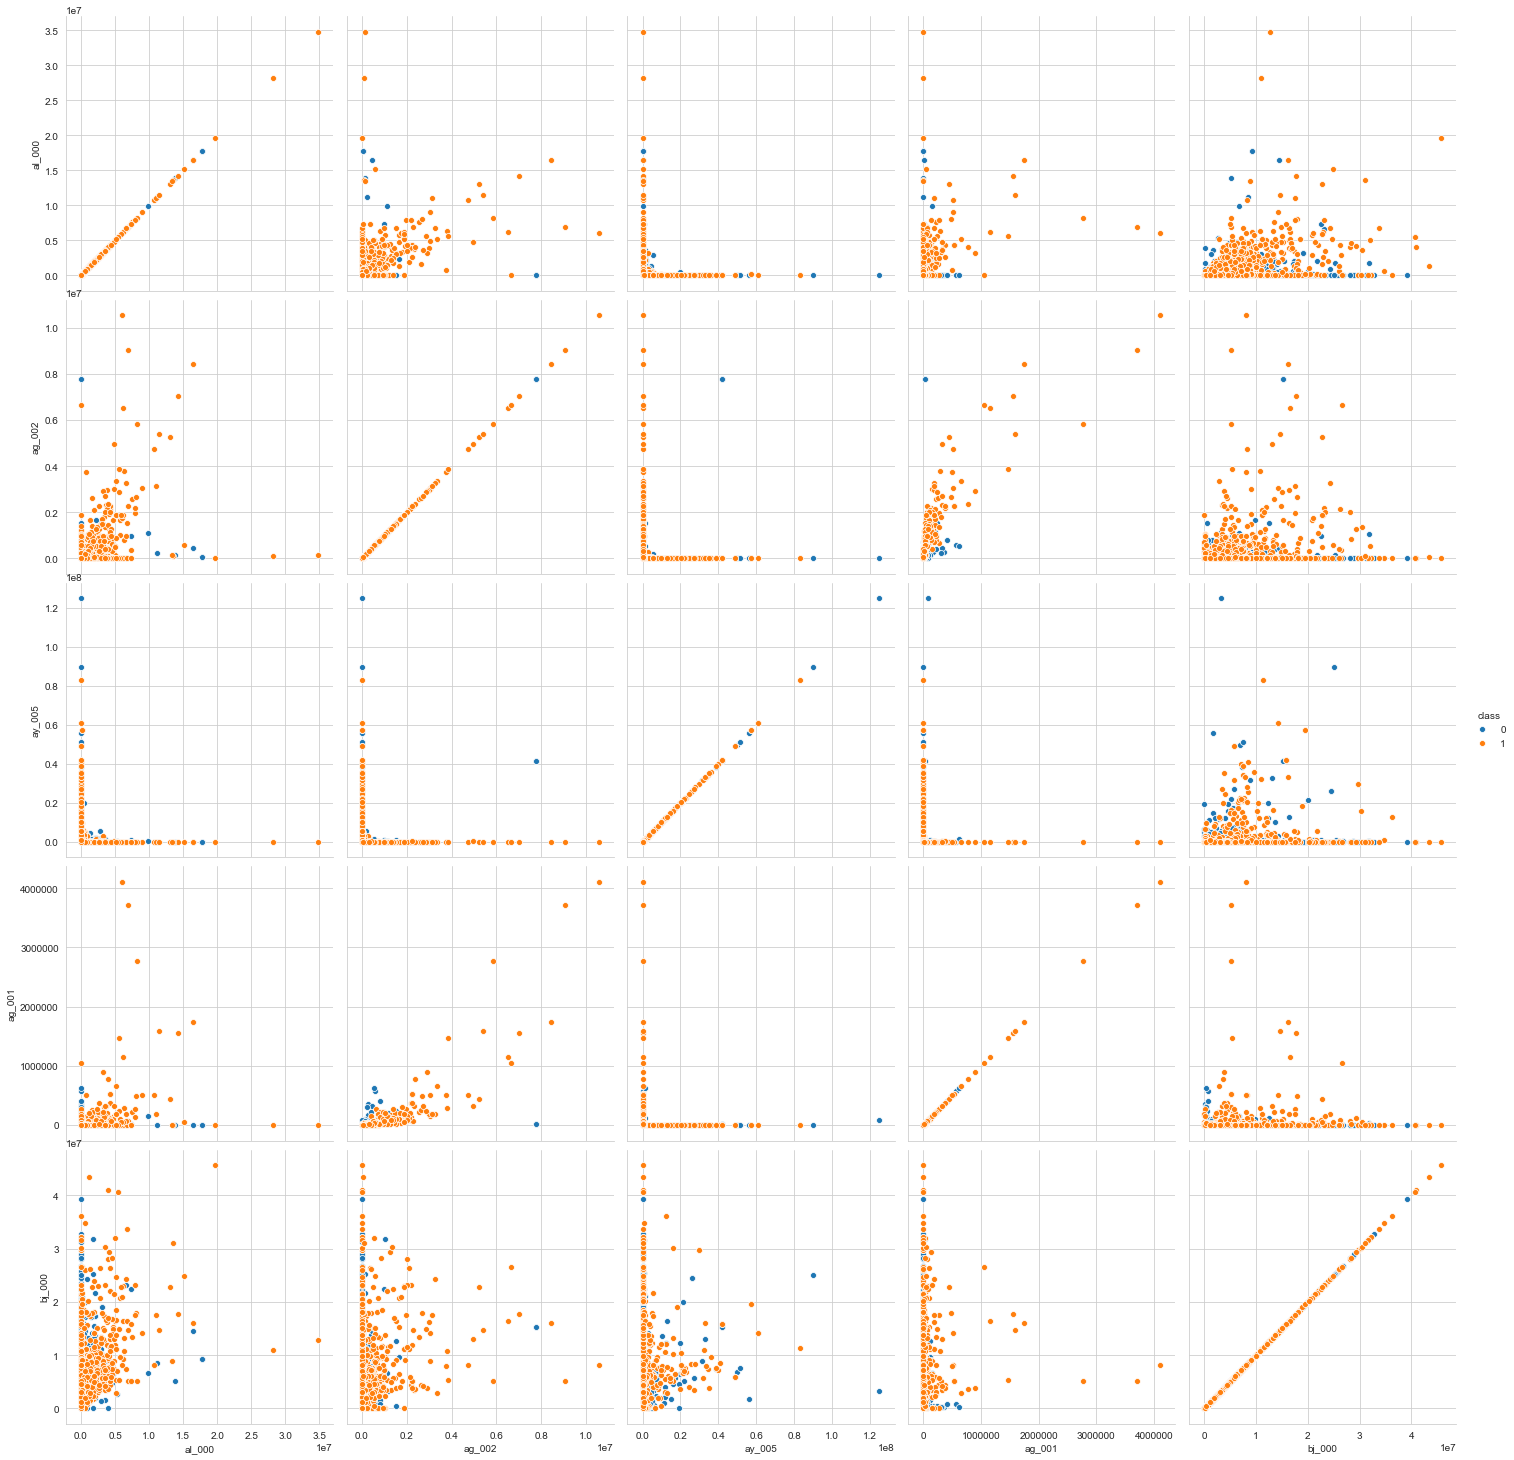

In [49]:
sns.set_style("whitegrid")
sns.pairplot(train_df_5, hue="class", size=4,diag_kind=None)
plt.show()

#### Observations

1 - All the poins brlonging to pos and neg classes are  are jumbled up, and there is not much clear seperability between
    classes using any pair of features                                                                                       
2 - Combination of ag_002 and ag_001 feature might be useful in seperating classes

### 4.10 Multivariate analysis using tsne

In [50]:
df = train_df_10.sample(frac=1)
df = df.head(10000)

target = df["class"]
df = df.drop(["class"],axis=1)# dropping class labels

Tsne with perplecity 30

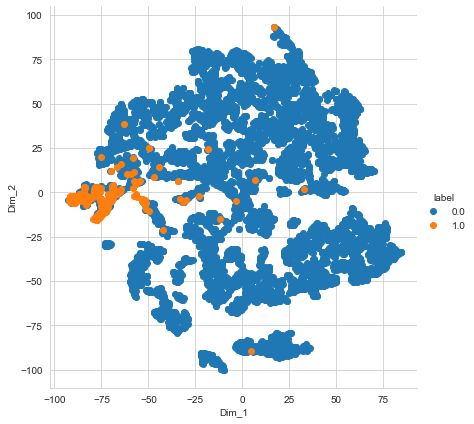

In [51]:
# # code taken from aaic mnist notebook 
model = TSNE(n_components=2, random_state=0,perplexity=30.0)
tsne_data = model.fit_transform(df)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, target)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Tsne with perplecity 50

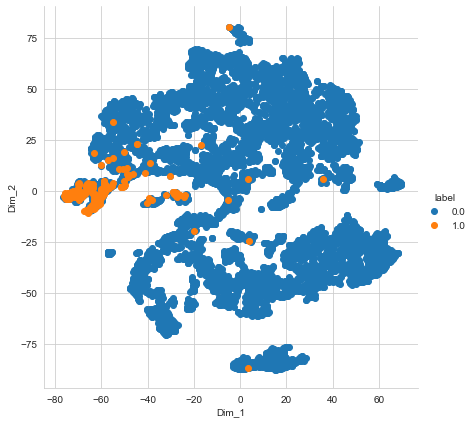

In [52]:
model = TSNE(n_components=2, random_state=0,perplexity=50.0)
tsne_data = model.fit_transform(df)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, target)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### 4.9.4 Observation and Conclusions from tsne

1 - data points with pos label is forming a small cluster                                                                      
2 - But seperation between pos and neg class is not fully seperable

### 4.11 summarizing Exploritory Data Analysis

1 - Data is highly imbalance                                                                                                 
2 - There are lots of missing value in data                                                                                  
3 - There is only column with no missing value                                                                              
4 - one column has very high missing value 82%                                                                               
5 - we replaced and dropped missing values based on percentage of missing values 
6 - in every features valued between 0 to 60th percwntile is significantly lower(Zero) in comparison with valuee between 60th to 100th percentile.                                                                                                                                            

## Balancing dataset

In [8]:
# code taken from https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/
train_df = pd.read_csv("clean_train.csv")# read unbalance data
target = train_df["class"]
train_df = train_df.drop(["class"],axis=1)

over_samp = RandomOverSampler()
train_df_bal, target_bal = over_samp.fit_sample(train_df, target.ravel()) 
train_df_bal["class"] = target_bal

# store balanced data into disk
train_df_bal.to_csv("train_clean_balanced.csv",index=False)

In [11]:
train_df_bal.to_csv("train_clean_balanced.csv",index=False)

## 5 - Feature Engg

### we will try following feature engg
1 - Taking sin of all the top 10 features thta we got above using feature importance                                      
2 - log(x+1) for same features (here we are not using log(x) because some values are 0)                                     
3 - Absolute deviation of all points from median for bi_000, ay_006, cc_000, ay_008, bj_000 features(here we are not taking all features because median for some features are zero)

In [17]:
train_bal = pd.read_csv("train_clean_balanced.csv")
train = pd.read_csv("clean_train.csv")
cv = pd.read_csv("clean_cv.csv")
test = pd.read_csv("clean_test.csv")

top_10 = ['bi_000', 'ay_002', 'ay_006', 'cc_000', 'ay_008', 'al_000', 'ag_001','ag_002', 'bj_000', 'ay_005'] 
top_4 = ["ay_006", "cc_000", "ay_008", "bj_000"]

In [13]:
for i in tqdm(top_10):
    temp1 = i + "_sin"
    temp2 = i + "_log"
    
    train_bal[temp2] = train_bal[i].apply(lambda x: math.log(x+1))
    train_bal[temp1] = train_bal[i].apply(lambda x: math.sin(x))
    
    train[temp2] = train[i].apply(lambda x: math.log(x+1))
    train[temp1] = train[i].apply(lambda x: math.sin(x))
    
    cv[temp2] = cv[i].apply(lambda x: math.log(x+1))
    cv[temp1] = cv[i].apply(lambda x: math.sin(x))
    
    test[temp2] = test[i].apply(lambda x: math.log(x+1))
    test[temp1] = test[i].apply(lambda x: math.sin(x))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.74it/s]


In [18]:
top_4_median = list(train[top_4].median())

for i in tqdm(range(4)):
    
    temp1 = top_4[i] + "_median"

    train_bal[temp1] = train_bal[top_4[i]] - top_4_median[i]
    
    train[temp1] = train[top_4[i]] - top_4_median[i]
    
    cv[temp1] = cv[top_4[i]] - top_4_median[i]
    
    test[temp1] = test[top_4[i]] - top_4_median[i]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 66.65it/s]


In [19]:
top_4_median = top_4_median)

[165116.0, 2112040.0, 92906.0, 154640.0]

In [15]:
# save dataset after balancing to disk
train.to_csv("train_clean_feature.csv",index=False)
train_bal.to_csv("train_bal_clean_feature.csv",index=False)
cv.to_csv("cv_clean_feature.csv",index=False)
test.to_csv("test_clean_feature.csv",index=False)

## 6 - Modelling

define some utility functions

In [2]:
def confusion_mat(cm_cv,cm_test):
    """
    this function takes train,cv,test confusion matrix as input and plots heatmap for confusion matrix 
    """
    plt.figure(figsize=(14, 4))
    plt.subplot(1,3,2)
    sns.heatmap(cm_cv, annot=True,fmt="d",cmap='Blues')
    plt.xlabel("actual class label")
    plt.ylabel("predicted class label")
    plt.title("CV confusion matrix")
    plt.show()
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1,3,3)
    sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
    plt.xlabel("actual class label")
    plt.ylabel("predicted class label")
    plt.title("Test confusion matrix")
    plt.show()

In [3]:
def best_hyper(hyperparameter,macro_f1_train,macro_f1_cv):
    """
    Takes hyperparameter,macro_f1_train,macro_f1_cv as input and plots huperparameter vs f1 score plot
    for train and cv 
    """

    plt.plot(hyperparameter,macro_f1_train, label='train macro_f1 score')
    plt.plot(hyperparameter,macro_f1_cv, label='cv macro_f1 score')
    plt.ylabel("macro_f1 score")
    plt.xlabel("hyper paramater")
    plt.title('Hyper-parameter VS macro_f1 score plot')
    plt.legend()
    plt.show()

In [4]:
def total_cost(conf_mat_cv,conf_mat_test):
    """
    takes confusion matrix for test and cv as input and returns total cost
    """
    x = conf_mat_cv[0][1]*500 + conf_mat_cv[1][0]*10
    y = conf_mat_test[0][1]*500 + conf_mat_test[1][0]*10
    
    print("Total cost on CV data is ",x)
    print("Total cost on Test data is ",y)

In [5]:
def custom_model(train,cv,test,test_also=0,base_learners=10,n_estimators=100):
    """
    in this function we are implementing custom stacling classifier
    1 - we take tarin dat and split it into 50% say set1 and set2
    2 - then randomly select samples say(10) with replacement and buils k decesion tress from set 1
    3 - then use set 2 to predict target column of set2 and using this create new dataset
    4  -new data will have no of features = k
    5 - now on this new dataset train a XGBoost with n_estimators = 100 an dmake final predictions
    """
    train1,train2 = train_test_split(train,test_size=0.5,random_state=1,stratify=train["class"])
    
    samples = []
    for i in range(10):
        samples.append(train1.sample(frac=0.1, replace=True))
    
    classifiers = []
    for sample_data in samples:
        y = sample_data["class"]
        x = sample_data.drop(["class"],axis=1)
        clf = DecisionTreeClassifier(max_depth=6,splitter="best")
        clf.fit(x,y)
        classifiers.append(clf)
    
    y_train2 = train2["class"]
    x_train2 = train2.drop(["class"],axis=1)
    
    y_cv = cv["class"]
    x_cv = cv.drop(["class"],axis=1)
    
    if test_also:
        y_test = test["class"]
        x_test = test.drop(["class"],axis=1)
    
    new_dataset_train = []
    new_dataset_cv = []
    if test_also:
        new_dataset_test = []

    for classifier in classifiers:
        new_dataset_train.append(classifier.predict(x_train2))
        new_dataset_cv.append(classifier.predict(x_cv))
        if test_also:
            new_dataset_test.append(classifier.predict(x_test))
        
    
    new_dataset_train = np.array(new_dataset_train)
    new_dataset_train = new_dataset_train.T
    
    new_dataset_cv = np.array(new_dataset_cv)
    new_dataset_cv = new_dataset_cv.T
    
    if test_also:
        new_dataset_test = np.array(new_dataset_test)
        new_dataset_test = new_dataset_test.T
    
    clf = XGBClassifier(n_estimators=n_estimators, n_jobs=-1,verbosity=0,learning_rate=0.1)
    clf.fit(new_dataset_train,y_train2)
    y_train_pred = clf.predict(new_dataset_train)
    y_cv_pred = clf.predict(new_dataset_cv)
    
    if test_also:
        y_test_pred = clf.predict(new_dataset_test)
    
    f1_train = f1_score(y_train2,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    
    if test_also:
        f1_test = f1_score(y_test,y_test_pred, average='macro')
        
        
    if test_also:
        print("train macro f1 is ",f1_train,"cv macro f1 is ",f1_cv,"Test macro f1 is ",f1_test,"for no of base learners = ",base_learners)
    
    else:
        
        print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for no of base learners = ",base_learners)
        print("---------------------------------------------------------------------------------------------------")
        
    if test_also:
        return y_train2,y_train_pred,y_cv,y_cv_pred,y_test,y_test_pred

### 6.1 Modelling on actual dataset (without feature engineering)

In [9]:
# reding dataset 
train = pd.read_csv("clean_train.csv")#,nrows=1000)
cv = pd.read_csv("clean_cv.csv")#,nrows=1000)
test = pd.read_csv("clean_test.csv")#,nrows=1000)

print("shape of train data is ",train.shape)
print("shape of train data is ",cv.shape)
print("shape of train data is ",test.shape)

shape of train data is  (48000, 166)
shape of train data is  (12000, 166)
shape of train data is  (16000, 166)


In [3]:
y_train = train["class"]
x_train = train.drop(["class"],axis=1)

y_cv = cv["class"]
x_cv = cv.drop(["class"],axis=1)

y_test = test["class"]
x_test = test.drop(["class"],axis=1)

#### 6.1.1 SGD Classifier with log loss/Logistic Regression

In [4]:
# For Logistic Regression we will standardized the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_cv_std = scaler.transform(x_cv)
x_test_std = scaler.transform(x_test)

In [5]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
macro_f1_train = []
macro_f1_cv = []

for i in alpha:
    clf = linear_model.SGDClassifier(alpha=i, loss='log', penalty='l2')
    clf.fit(x_train_std,y_train)
    y_train_pred = clf.predict(x_train_std)
    y_cv_pred = clf.predict(x_cv_std)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for alpha = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.8320775404624633 and cv macro f1 is  0.8167881494099634 for alpha =  0.0001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8063168007685841 and cv macro f1 is  0.795254293699769 for alpha =  0.001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7928084485574178 and cv macro f1 is  0.8010594784106286 for alpha =  0.01
---------------------------------------------------------------------------------------------------
train macro f1 is  0.765478654734043 and cv macro f1 is  0.7754800935402415 for alpha =  0.1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.6982176821379232 and cv macro f1 is  0.6900810438070444 for alpha =  1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7312830

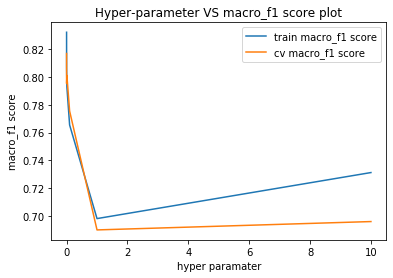

In [11]:
best_hyper(alpha,macro_f1_train,macro_f1_cv)

prediction on test data using best set of hyperparameters

In [12]:
clf = linear_model.SGDClassifier(alpha=0.0001, loss='log', penalty='l2')
clf.fit(x_train_std,y_train)

y_train_pred = clf.predict(x_train_std)
y_cv_pred = clf.predict(x_cv_std)
y_test_pred = clf.predict(x_test_std)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  0.8432072832812822 CV macro f1 is  0.8235215473060297 and Test macro f1 is  0.8497252598229172 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  28760
Total cost on Test data is  29400


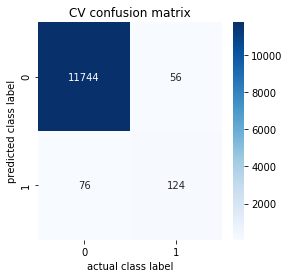

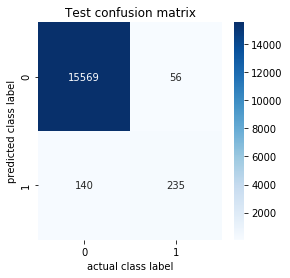

In [14]:
confusion_mat(cm_cv,cm_test)

#### 6.1.2 SGD Classifier with hinge loss and l2 regularization/SVM

In [15]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
macro_f1_train = []
macro_f1_cv = []

for i in alpha:
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', penalty='l2')
    clf.fit(x_train_std,y_train)
    y_train_pred = clf.predict(x_train_std)
    y_cv_pred = clf.predict(x_cv_std)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for alpha = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.8444234281954774 and cv macro f1 is  0.827978833205 for alpha =  0.0001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8205591695385871 and cv macro f1 is  0.8064732365107405 for alpha =  0.001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7726082557928817 and cv macro f1 is  0.7837603026202484 for alpha =  0.01
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7572170928338444 and cv macro f1 is  0.7479898649417973 for alpha =  0.1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.6997698848211298 and cv macro f1 is  0.670365688064803 for alpha =  1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.4983025010

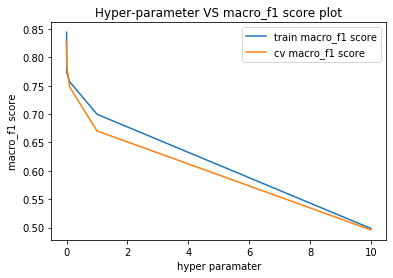

In [16]:
best_hyper(alpha,macro_f1_train,macro_f1_cv)

prediction on test data using best set of hyperparameters

In [17]:
clf = linear_model.SGDClassifier(alpha=0.0001, loss='log', penalty='l2')
clf.fit(x_train_std,y_train)

y_train_pred = clf.predict(x_train_std)
y_cv_pred = clf.predict(x_cv_std)
y_test_pred = clf.predict(x_test_std)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.8339138435511232 CV macro f1 is -  0.8215214466539941 and Test macro f1 is -  0.8425630965228151 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  24810
Total cost on Test data is  25020


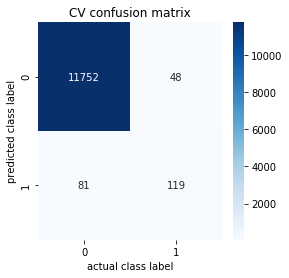

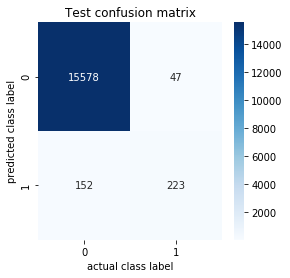

In [18]:
confusion_mat(cm_cv,cm_test)

#### 6.1.3 Random forest

In [19]:
n_estimators = [25,50,75,100,150]
macro_f1_train = []
macro_f1_cv = []

for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=15)
    #print(clf)
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    y_cv_pred = clf.predict(x_cv)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for no of estimators = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.9822497222478722 and cv macro f1 is  0.8850058361875415 for no of estimators =  25
---------------------------------------------------------------------------------------------------
train macro f1 is  0.980544281822563 and cv macro f1 is  0.8850058361875415 for no of estimators =  50
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9822497222478722 and cv macro f1 is  0.891207117472137 for no of estimators =  75
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9819095033182186 and cv macro f1 is  0.8917924579343179 for no of estimators =  100
---------------------------------------------------------------------------------------------------
train macro f1 is  0.983267785040715 and cv macro f1 is  0.8845454993320214 for no of estimators =  150
---------------------------------------------------------------------------------

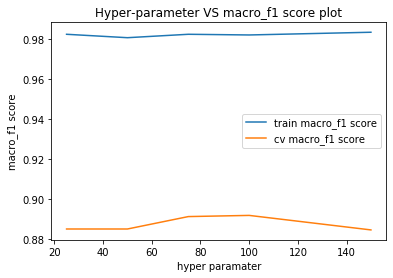

In [20]:
best_hyper(n_estimators,macro_f1_train,macro_f1_cv)

prediction on test data using best set of hyperparameters

In [29]:
clf = RandomForestClassifier(n_estimators=75,n_jobs=-1,max_depth=15)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9825895082857619 CV macro f1 is -  0.88830131873961 and Test macro f1 is -  0.8919706817824211 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  10100
Total cost on Test data is  11180


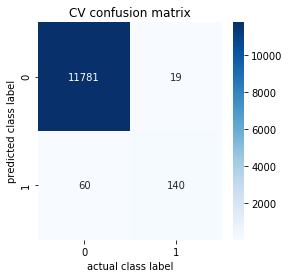

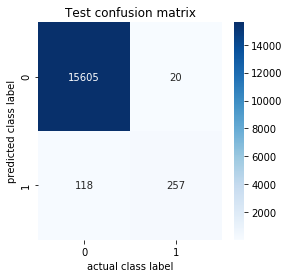

In [30]:
confusion_mat(cm_cv,cm_test)

#### 6.1.4 XGBoost

In [23]:
estimators = [25,50,80,120,150]
learning_rate = [0.01,0.05,0.1]
macro_f1_train = []
macro_f1_cv = []

for i in estimators:
    for j in learning_rate:
        clf = XGBClassifier(n_estimators=i, n_jobs=-1,verbosity=0,learning_rate=j)
        clf.fit(x_train,y_train)
        y_train_pred = clf.predict(x_train)
        y_cv_pred = clf.predict(x_cv)
        f1_train = f1_score(y_train,y_train_pred, average='macro')
        f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
        print('Estimators = ',i,'learning rate = ',j,'Train macro F1',f1_train,'CV Macro f1',f1_cv)#,'test Macro f1',f1_test)
        print("---------------------------------------------------------------------------------------------------")
        macro_f1_train.append(f1_train)
        macro_f1_cv.append(f1_cv)

Estimators =  25 learning rate =  0.01 Train macro F1 0.8943473685865375 CV Macro f1 0.8298779779544256
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.05 Train macro F1 0.9135093921533004 CV Macro f1 0.8635992752949813
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.1 Train macro F1 0.9432011018347402 CV Macro f1 0.8720159856162482
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.01 Train macro F1 0.898939856769575 CV Macro f1 0.8453160954746646
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.05 Train macro F1 0.9415703403991988 CV Macro f1 0.8768636337380269
----------------------------------------------------------------------------------

prediction on test data using best set of hyperparameters

In [25]:
clf = XGBClassifier(n_estimators=150, n_jobs=-1,verbosity=0,learning_rate=0.1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9987256816249344 CV macro f1 is -  0.9084608588914189 and Test macro f1 is -  0.9199607695566299 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  13430
Total cost on Test data is  10870


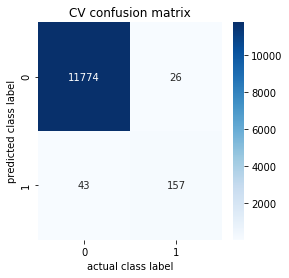

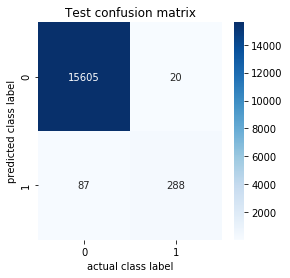

In [26]:
confusion_mat(cm_cv,cm_test)

#### 6.1.5 AdaBoost

In [34]:
estimators = [25,50,80,120,150]
learning_rate = [0.1,0.5,1]
macro_f1_train = []
macro_f1_cv = []

for i in estimators:
    for j in learning_rate:
        clf = AdaBoostClassifier(n_estimators=i, learning_rate=j)
        clf.fit(x_train,y_train)
        y_train_pred = clf.predict(x_train)
        y_cv_pred = clf.predict(x_cv)
        f1_train = f1_score(y_train,y_train_pred, average='macro')
        f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
        print('Estimators = ',i,'learning rate = ',j,'Train macro F1',f1_train,'CV Macro f1',f1_cv)#,'test Macro f1',f1_test)
        print("---------------------------------------------------------------------------------------------------")
        macro_f1_train.append(f1_train)
        macro_f1_cv.append(f1_cv)

Estimators =  25 learning rate =  0.1 Train macro F1 0.6513923153793522 CV Macro f1 0.6458210463682773
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.5 Train macro F1 0.8097535329215566 CV Macro f1 0.8004102045510275
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  1 Train macro F1 0.8219088248296413 CV Macro f1 0.818601098072707
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.1 Train macro F1 0.7306204914468177 CV Macro f1 0.7094420028628138
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.5 Train macro F1 0.8446156692793343 CV Macro f1 0.8439125727602362
----------------------------------------------------------------------------------------

In [36]:
clf = AdaBoostClassifier(n_estimators=120, learning_rate=1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9145003872923816 CV macro f1 is -  0.884423049269379 and Test macro f1 is -  0.8822218749517952 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  16540
Total cost on Test data is  23130


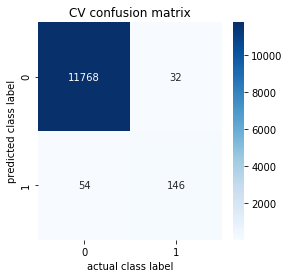

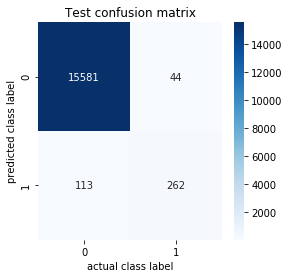

In [37]:
confusion_mat(cm_cv,cm_test)

#### 6.1.6 Custom Ensemble

In [16]:
base_learner = [5,10,15,20,25,30]
for i in base_learner:
    custom_model(train=train,cv=cv,test=test,test_also=0,base_learners=i,n_estimators=100)

train macro f1 is  0.889921044558746 and cv macro f1 is  0.7933066698937496 for no of base learners =  5
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8869556371967562 and cv macro f1 is  0.7692369820812517 for no of base learners =  10
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8842903950231855 and cv macro f1 is  0.8021302197067606 for no of base learners =  15
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8866468558774323 and cv macro f1 is  0.7894456537557633 for no of base learners =  20
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8889107499825105 and cv macro f1 is  0.8028025119603424 for no of base learners =  25
-------------------------------------------------------------------

In [17]:
y_train,y_train_pred,y_cv,y_cv_pred,y_test,y_test_pred = custom_model(train=train,cv=cv,test=test,test_also=1,base_learners=25)

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

total_cost(cm_cv,cm_test)

train macro f1 is  0.8923105916379175 cv macro f1 is  0.8234158560013343 Test macro f1 is  0.8308896679285811 for no of base learners =  25
Total cost on CV data is  25790
Total cost on Test data is  32060


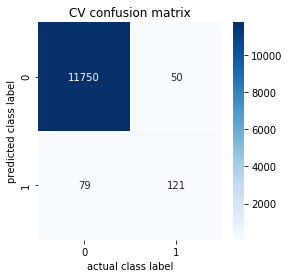

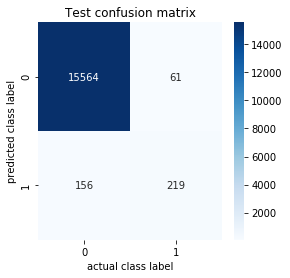

In [18]:
confusion_mat(cm_cv,cm_test)

### 6.2 Modelling after feature engineering

In [6]:
# reding dataset after feature engg
train = pd.read_csv("train_clean_feature.csv")#,nrows=1000)
cv = pd.read_csv("cv_clean_feature.csv")#,nrows=1000)
test = pd.read_csv("test_clean_feature.csv")#,nrows=1000)

print("shape of train data is ",train.shape)
print("shape of train data is ",cv.shape)
print("shape of train data is ",test.shape)

shape of train data is  (48000, 190)
shape of train data is  (12000, 190)
shape of train data is  (16000, 190)


In [7]:
y_train = train["class"]
x_train = train.drop(["class"],axis=1)

y_cv = cv["class"]
x_cv = cv.drop(["class"],axis=1)

y_test = test["class"]
x_test = test.drop(["class"],axis=1)

#### 6.2.1 SGD Classifier with log loss/Logistic Regression

In [21]:
# For Logistic Regression we will standardized the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_cv_std = scaler.transform(x_cv)
x_test_std = scaler.transform(x_test)

In [22]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
macro_f1_train = []
macro_f1_cv = []

for i in alpha:
    clf = linear_model.SGDClassifier(alpha=i, loss='log', penalty='l2')
    clf.fit(x_train_std,y_train)
    y_train_pred = clf.predict(x_train_std)
    y_cv_pred = clf.predict(x_cv_std)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for alpha = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.8467176425124052 and cv macro f1 is  0.8469417989417989 for alpha =  0.0001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8214805851266376 and cv macro f1 is  0.8138747884940778 for alpha =  0.001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7962393878435123 and cv macro f1 is  0.8030522351235254 for alpha =  0.01
---------------------------------------------------------------------------------------------------
train macro f1 is  0.774723735940944 and cv macro f1 is  0.7779677060645327 for alpha =  0.1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7188484030589293 and cv macro f1 is  0.7036660321827155 for alpha =  1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.741788

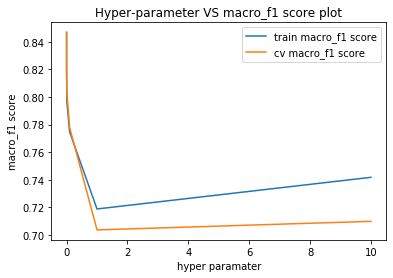

In [23]:
best_hyper(alpha,macro_f1_train,macro_f1_cv)

In [24]:
clf = linear_model.SGDClassifier(alpha=0.0001, loss='log', penalty='l2')
clf.fit(x_train_std,y_train)

y_train_pred = clf.predict(x_train_std)
y_cv_pred = clf.predict(x_cv_std)
y_test_pred = clf.predict(x_test_std)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  0.8552837803153175 CV macro f1 is  0.8392975954848287 and Test macro f1 is  0.8563222381144145 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  28670
Total cost on Test data is  34770


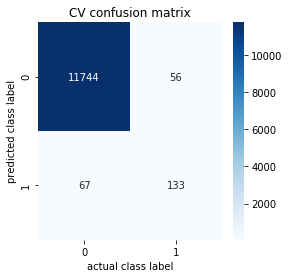

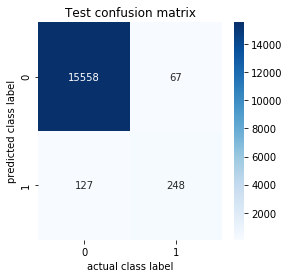

In [25]:
confusion_mat(cm_cv,cm_test)

#### 6.2.2 SGD Classifier with log loss and l2 regularization/SVM

In [26]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
macro_f1_train = []
macro_f1_cv = []

for i in alpha:
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', penalty='l2')
    clf.fit(x_train_std,y_train)
    y_train_pred = clf.predict(x_train_std)
    y_cv_pred = clf.predict(x_cv_std)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for alpha = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.8549857704787283 and cv macro f1 is  0.8393856985690846 for alpha =  0.0001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8291631795424694 and cv macro f1 is  0.8225608465608466 for alpha =  0.001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8061118828358804 and cv macro f1 is  0.8046385229505999 for alpha =  0.01
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7688688465940734 and cv macro f1 is  0.7535224777036665 for alpha =  0.1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.7258341527634331 and cv macro f1 is  0.705218541632422 for alpha =  1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.498302

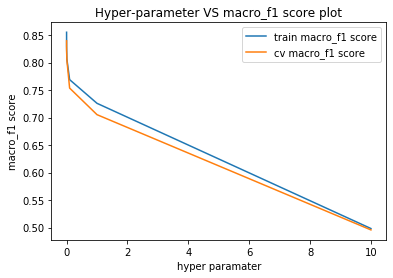

In [27]:
best_hyper(alpha,macro_f1_train,macro_f1_cv)

In [28]:
clf = linear_model.SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
clf.fit(x_train_std,y_train)

y_train_pred = clf.predict(x_train_std)
y_cv_pred = clf.predict(x_cv_std)
y_test_pred = clf.predict(x_test_std)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  0.8463418892963157 CV macro f1 is  0.8430516435463413 and Test macro f1 is  0.8571089205114786 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  25680
Total cost on Test data is  25370


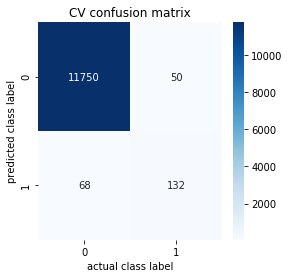

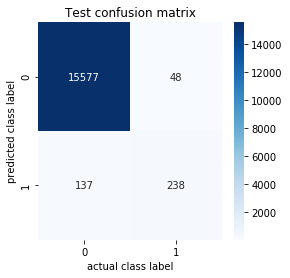

In [29]:
confusion_mat(cm_cv,cm_test)

#### 6.2.3 Random forest

In [30]:
n_estimators = [25,50,75,100,150]
macro_f1_train = []
macro_f1_cv = []

for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=15)
    #print(clf)
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    y_cv_pred = clf.predict(x_cv)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for no of estimators = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.9771005095212686 and cv macro f1 is  0.8956736439747182 for no of estimators =  25
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9802018857703804 and cv macro f1 is  0.899575800743511 for no of estimators =  50
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9819095033182186 and cv macro f1 is  0.8934200432957702 for no of estimators =  75
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9829288622710457 and cv macro f1 is  0.8956736439747182 for no of estimators =  100
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9822497222478722 and cv macro f1 is  0.893996678562595 for no of estimators =  150
--------------------------------------------------------------------------------

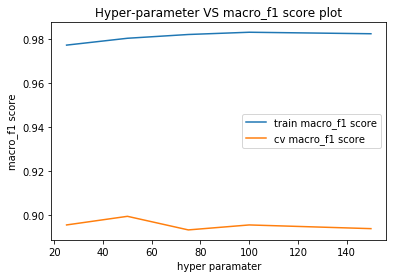

In [31]:
best_hyper(n_estimators,macro_f1_train,macro_f1_cv)

In [32]:
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=15)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9822497222478722 CV macro f1 is -  0.893996678562595 and Test macro f1 is -  0.8925921880710788 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  10560
Total cost on Test data is  10680


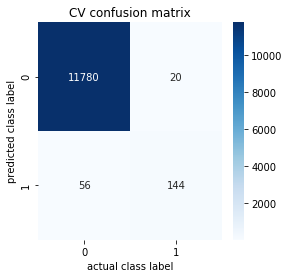

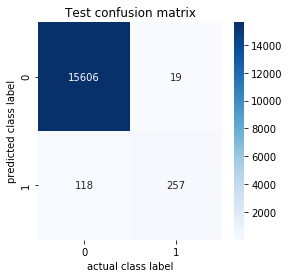

In [33]:
confusion_mat(cm_cv,cm_test)

#### 6.1.4 XG Boost

In [34]:
estimators = [25,50,75,120,150]
learning_rate = [0.01,0.05,0.1]
macro_f1_train = []
macro_f1_cv = []
#macro_f1_test = []

for i in estimators:
    for j in learning_rate:
        clf = XGBClassifier(n_estimators=i, n_jobs=-1,verbosity=0,learning_rate=j)
        clf.fit(x_train,y_train)
        y_train_pred = clf.predict(x_train)
        y_cv_pred = clf.predict(x_cv)
        f1_train = f1_score(y_train,y_train_pred, average='macro')
        f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
        #f1_test = f1_score(y_test,y_test_pred, average='macro')
        print('Estimators = ',i,'learning rate = ',j,'Train macro F1',f1_train,'CV Macro f1',f1_cv)#,'test Macro f1',f1_test)
        print("---------------------------------------------------------------------------------------------------")
        macro_f1_train.append(f1_train)
        macro_f1_cv.append(f1_cv)
        #macro_f1_test.append(f1_test)
    print("*******************************************************************************************************")

Estimators =  25 learning rate =  0.01 Train macro F1 0.8929147905334736 CV Macro f1 0.8337509437344526
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.05 Train macro F1 0.9161358856695582 CV Macro f1 0.863891502623633
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.1 Train macro F1 0.9435876823704457 CV Macro f1 0.8851649618006319
---------------------------------------------------------------------------------------------------
*******************************************************************************************************
Estimators =  50 learning rate =  0.01 Train macro F1 0.8990807662957234 CV Macro f1 0.8434309876170341
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.05 Train macro F1 0.9431242309204203 CV Macro 

In [8]:
clf = XGBClassifier(n_estimators=150, n_jobs=-1,verbosity=0,learning_rate=0.1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9118351618577406 CV macro f1 is -  0.8545845776014629 and Test macro f1 is -  0.8658899858455411 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  15230
Total cost on Test data is  16880


In [9]:
my_model = "model.pkl"
joblib.dump(clf,my_model)

my_model = "model.pkl"
clf = joblib.load(my_model)

In [16]:
test.iloc[1:4]

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,...,ag_002_log,ag_002_sin,bj_000_log,bj_000_sin,ay_005_log,ay_005_sin,ay_006_median,cc_000_median,ay_008_median,bj_000_median
1,82,68.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,...,0.0,0.0,8.050384,-0.966048,0.000000,0.000000,-165116.0,-2094990.0,-76620.0,-151506.0
2,66002,212.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,...,0.0,0.0,12.489344,0.753627,10.097697,0.996639,516144.0,1879512.0,381876.0,110852.0
3,59816,1010.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,984314.0,...,0.0,0.0,12.663912,-0.816918,8.762333,-0.909523,925988.0,1918158.0,-90894.0,161490.0


In [11]:
y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9118351618577406 CV macro f1 is -  0.8545845776014629 and Test macro f1 is -  0.8658899858455411 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  15230
Total cost on Test data is  16880


In [36]:
clf = XGBClassifier(n_estimators=150, n_jobs=-1,verbosity=0,learning_rate=0.1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9987256816249344 CV macro f1 is -  0.9037390258032889 and Test macro f1 is -  0.914630486253698 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  13460
Total cost on Test data is  8960


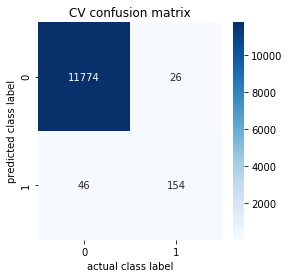

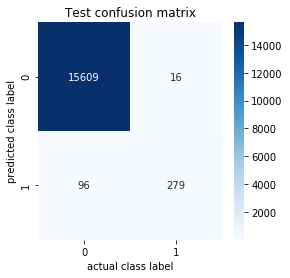

In [37]:
confusion_mat(cm_cv,cm_test)

#### 6.2.5 AdaBoost

In [39]:
estimators = [25,50,75,120,150]
learning_rate = [0.1,0.5,1]
macro_f1_train = []
macro_f1_cv = []
#macro_f1_test = []

for i in estimators:
    for j in learning_rate:
        clf = AdaBoostClassifier(n_estimators=i,learning_rate=j)
        clf.fit(x_train,y_train)
        y_train_pred = clf.predict(x_train)
        y_cv_pred = clf.predict(x_cv)
        f1_train = f1_score(y_train,y_train_pred, average='macro')
        f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
        #f1_test = f1_score(y_test,y_test_pred, average='macro')
        print('Estimators = ',i,'learning rate = ',j,'Train macro F1',f1_train,'CV Macro f1',f1_cv)#,'test Macro f1',f1_test)
        print("---------------------------------------------------------------------------------------------------")
        macro_f1_train.append(f1_train)
        macro_f1_cv.append(f1_cv)
        #macro_f1_test.append(f1_test)
    print("*******************************************************************************************************")

Estimators =  25 learning rate =  0.1 Train macro F1 0.6513923153793522 CV Macro f1 0.6458210463682773
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.5 Train macro F1 0.8121803306069015 CV Macro f1 0.7997743936830232
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  1 Train macro F1 0.8368354004504015 CV Macro f1 0.8217229670972757
---------------------------------------------------------------------------------------------------
*******************************************************************************************************
Estimators =  50 learning rate =  0.1 Train macro F1 0.7306204914468177 CV Macro f1 0.7094420028628138
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.5 Train macro F1 0.8377605354905133 CV Macro f1 0.

Prediction on test data for best set of parameters

In [41]:
clf =  AdaBoostClassifier(n_estimators=120,learning_rate=1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9098607210523039 CV macro f1 is -  0.8689362538704762 and Test macro f1 is -  0.8759380696924552 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  17620
Total cost on Test data is  22210


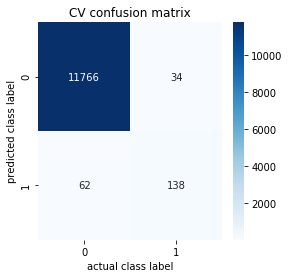

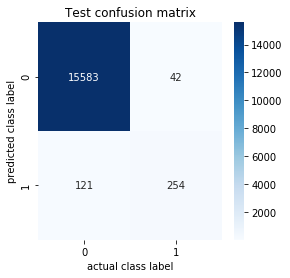

In [42]:
confusion_mat(cm_cv,cm_test)

#### 6.2.6 custom ensemble

In [43]:
base_learner = [5,10,15,20,25,30]
for i in base_learner:
    custom_model(train=train,cv=cv,test=test,test_also=0,base_learners=i,n_estimators=100)

train macro f1 is  0.883556430985442 and cv macro f1 is  0.7784362761743651 for no of base learners =  5
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8813473661708542 and cv macro f1 is  0.7883418906674722 for no of base learners =  10
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8868874113818835 and cv macro f1 is  0.8028025119603424 for no of base learners =  15
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8901787469496714 and cv macro f1 is  0.8083967669401907 for no of base learners =  20
---------------------------------------------------------------------------------------------------
train macro f1 is  0.8928369994359842 and cv macro f1 is  0.7869900732370539 for no of base learners =  25
-------------------------------------------------------------------

In [44]:
y_train,y_train_pred,y_cv,y_cv_pred,y_test,y_test_pred = custom_model(train=train,cv=cv,test=test,test_also=1,base_learners=30)

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

total_cost(cm_cv,cm_test)

train macro f1 is  0.8936652364247133 cv macro f1 is  0.7966174624661794 Test macro f1 is  0.8176001342979542 for no of base learners =  30
Total cost on CV data is  29400
Total cost on Test data is  28720


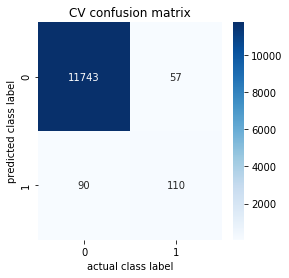

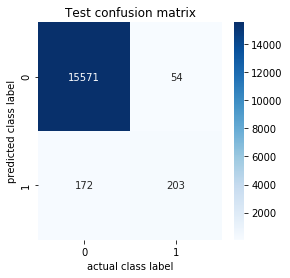

In [45]:
confusion_mat(cm_cv,cm_test)

## 6.3 Modelling after feature engg and balance the data

reading data after feature engg and balancing

In [6]:
train = pd.read_csv("train_bal_clean_feature.csv")
cv = pd.read_csv("cv_clean_feature.csv")
test = pd.read_csv("test_clean_feature.csv")

print("shape of train data is ",train.shape)
print("shape of train data is ",cv.shape)
print("shape of train data is ",test.shape)

shape of train data is  (94400, 190)
shape of train data is  (12000, 190)
shape of train data is  (16000, 190)


In [7]:
y_train = train["class"]
x_train = train.drop(["class"],axis=1)

y_cv = cv["class"]
x_cv = cv.drop(["class"],axis=1)

y_test = test["class"]
x_test = test.drop(["class"],axis=1)

In [6]:
# For Logistic Regression we will standardized the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_cv_std = scaler.transform(x_cv)
x_test_std = scaler.transform(x_test)

#### 6.3.1 SGD Classifier with log loss

In [26]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
macro_f1_train = []
macro_f1_cv = []

for i in alpha:
    clf = linear_model.SGDClassifier(alpha=i, loss='log', penalty='l2')
    clf.fit(x_train_std,y_train)
    y_train_pred = clf.predict(x_train_std)
    y_cv_pred = clf.predict(x_cv_std)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for alpha = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.9668284840106803 and cv macro f1 is  0.7664378283195914 for alpha =  0.0001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9640105542699761 and cv macro f1 is  0.746123930515945 for alpha =  0.001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9609395773609923 and cv macro f1 is  0.723415775565434 for alpha =  0.01
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9445374677099992 and cv macro f1 is  0.7082166199813258 for alpha =  0.1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9367440610174228 and cv macro f1 is  0.6971419895267662 for alpha =  1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9339906

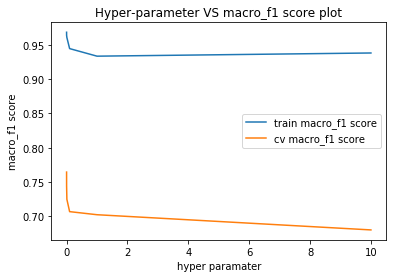

In [25]:
best_hyper(alpha,macro_f1_train,macro_f1_cv)

In [12]:
clf = linear_model.SGDClassifier(alpha=0.0001, loss='log', penalty='l2')
clf.fit(x_train_std,y_train)

y_train_pred = clf.predict(x_train_std)
y_cv_pred = clf.predict(x_cv_std)
y_test_pred = clf.predict(x_test_std)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  0.9681772557664607 CV macro f1 is  0.7424989442750667 and Test macro f1 is  0.796000507241982 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  174170
Total cost on Test data is  205830


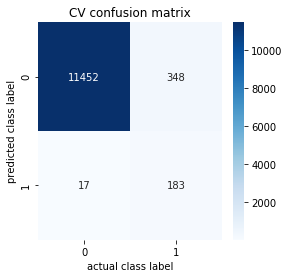

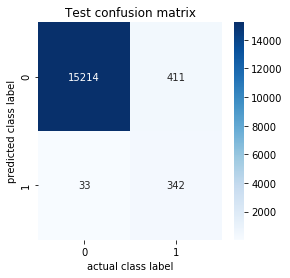

In [14]:
confusion_mat(cm_cv,cm_test)

### 6.3.2 SGD Classifier with Hinge loss

In [30]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
macro_f1_train = []
macro_f1_cv = []

for i in alpha:
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', penalty='l2')
    clf.fit(x_train_std,y_train)
    y_train_pred = clf.predict(x_train_std)
    y_cv_pred = clf.predict(x_cv_std)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for alpha = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.9708998114804872 and cv macro f1 is  0.7531834272617746 for alpha =  0.0001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.968727977856978 and cv macro f1 is  0.7535478835924504 for alpha =  0.001
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9621472160314257 and cv macro f1 is  0.7350666355959474 for alpha =  0.01
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9557689287084787 and cv macro f1 is  0.7072929097336366 for alpha =  0.1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9358626803363559 and cv macro f1 is  0.7148779547596478 for alpha =  1
---------------------------------------------------------------------------------------------------
train macro f1 is  0.921388

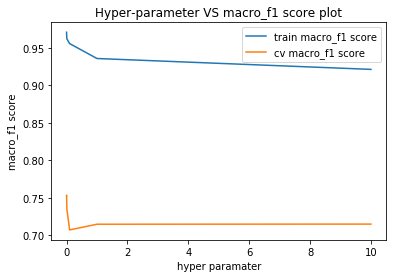

In [31]:
best_hyper(alpha,macro_f1_train,macro_f1_cv)

In [18]:
clf = linear_model.SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
clf.fit(x_train_std,y_train)

y_train_pred = clf.predict(x_train_std)
y_cv_pred = clf.predict(x_cv_std)
y_test_pred = clf.predict(x_test_std)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  0.9707303773774236 CV macro f1 is  0.7510188126712707 and Test macro f1 is  0.804133208179173 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  158700
Total cost on Test data is  190840


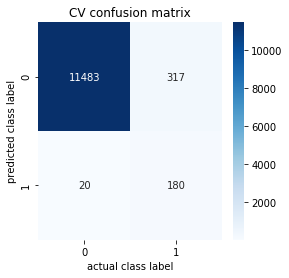

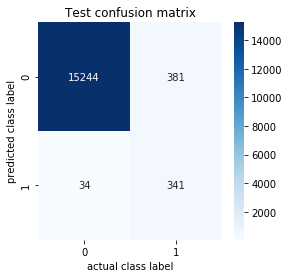

In [19]:
cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

confusion_mat(cm_cv,cm_test)

#### 6.3.3 Random Forest

In [8]:
n_estimators = [25,50,75,100,150]
macro_f1_train = []
macro_f1_cv = []

for i in n_estimators:
    clf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    #print(clf)
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    y_cv_pred = clf.predict(x_cv)
    f1_train = f1_score(y_train,y_train_pred, average='macro')
    f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
    print("train macro f1 is ",f1_train,"and cv macro f1 is ",f1_cv,"for no of estimators = ",i)
    print("---------------------------------------------------------------------------------------------------")
    macro_f1_train.append(f1_train)
    macro_f1_cv.append(f1_cv)

train macro f1 is  0.9999894067796598 and cv macro f1 is  0.8689362538704762 for no of estimators =  25
---------------------------------------------------------------------------------------------------
train macro f1 is  1.0 and cv macro f1 is  0.8716801898389308 for no of estimators =  50
---------------------------------------------------------------------------------------------------
train macro f1 is  1.0 and cv macro f1 is  0.875145143770367 for no of estimators =  75
---------------------------------------------------------------------------------------------------
train macro f1 is  1.0 and cv macro f1 is  0.8760903228925057 for no of estimators =  100
---------------------------------------------------------------------------------------------------
train macro f1 is  1.0 and cv macro f1 is  0.8758131936063112 for no of estimators =  150
---------------------------------------------------------------------------------------------------


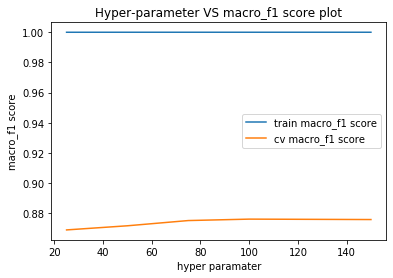

In [9]:
best_hyper(n_estimators,macro_f1_train,macro_f1_cv)

In [12]:
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  1.0 CV macro f1 is  0.870293779988814 and Test macro f1 is  0.8754964578742266 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  16130
Total cost on Test data is  17770


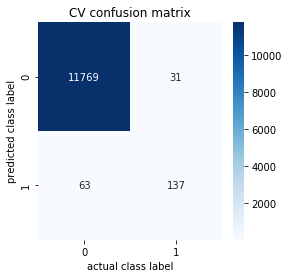

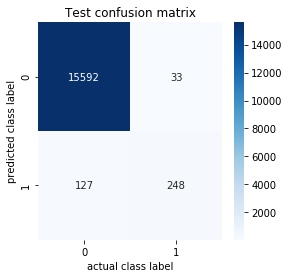

In [13]:
cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

confusion_mat(cm_cv,cm_test)

### 6.3.4 XG Boost

In [14]:
estimators = [25,50,75,100,150]
learning_rate = [0.05,0.1]
macro_f1_train = []
macro_f1_cv = []
#macro_f1_test = []

for i in estimators:
    for j in learning_rate:
        clf = XGBClassifier(n_estimators=i, n_jobs=-1,verbosity=0,learning_rate=j)
        clf.fit(x_train,y_train)
        y_train_pred = clf.predict(x_train)
        y_cv_pred = clf.predict(x_cv)
        f1_train = f1_score(y_train,y_train_pred, average='macro')
        f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
        #f1_test = f1_score(y_test,y_test_pred, average='macro')
        print('Estimators = ',i,'learning rate = ',j,'Train macro F1',f1_train,'CV Macro f1',f1_cv)#,'test Macro f1',f1_test)
        print("---------------------------------------------------------------------------------------------------")
        macro_f1_train.append(f1_train)
        macro_f1_cv.append(f1_cv)
        #macro_f1_test.append(f1_test)
    print("*******************************************************************************************************")

Estimators =  25 learning rate =  0.05 Train macro F1 0.9819678816390914 CV Macro f1 0.7177974706064594
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  0.1 Train macro F1 0.9882830735593504 CV Macro f1 0.7679127264465312
---------------------------------------------------------------------------------------------------
*******************************************************************************************************
Estimators =  50 learning rate =  0.05 Train macro F1 0.9887914339506292 CV Macro f1 0.7617047369910896
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  0.1 Train macro F1 0.9936226220030056 CV Macro f1 0.8005918689876919
---------------------------------------------------------------------------------------------------
**********************************************************************************

In [17]:
clf = XGBClassifier(n_estimators=150, n_jobs=-1,verbosity=0,learning_rate=0.1)
clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is ",f1_train,"CV macro f1 is ",f1_cv,"and Test macro f1 is ",f1_test,"for Best value of C")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is  0.9998728813538781 CV macro f1 is  0.8869577065466735 and Test macro f1 is  0.9188797190270463 for Best value of C
--------------------------------------------------------------------------------------------
Total cost on CV data is  33800
Total cost on Test data is  37980


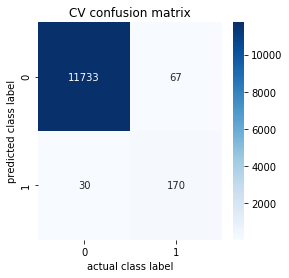

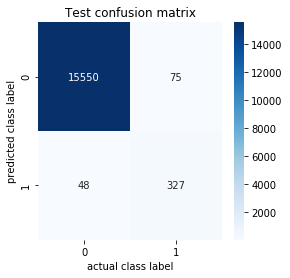

In [18]:
cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

confusion_mat(cm_cv,cm_test)

#### 6.3.5 Adaboost

In [19]:
estimators = [25,50,75,120,150]
learning_rate = [0.5,1]
macro_f1_train = []
macro_f1_cv = []
#macro_f1_test = []

for i in estimators:
    for j in learning_rate:
        clf = AdaBoostClassifier(n_estimators=i,learning_rate=j)
        clf.fit(x_train,y_train)
        y_train_pred = clf.predict(x_train)
        y_cv_pred = clf.predict(x_cv)
        f1_train = f1_score(y_train,y_train_pred, average='macro')
        f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
        #f1_test = f1_score(y_test,y_test_pred, average='macro')
        print('Estimators = ',i,'learning rate = ',j,'Train macro F1',f1_train,'CV Macro f1',f1_cv)#,'test Macro f1',f1_test)
        print("---------------------------------------------------------------------------------------------------")
        macro_f1_train.append(f1_train)
        macro_f1_cv.append(f1_cv)
        #macro_f1_test.append(f1_test)
    print("*******************************************************************************************************")

Estimators =  25 learning rate =  0.5 Train macro F1 0.9566609589485161 CV Macro f1 0.666941178042036
---------------------------------------------------------------------------------------------------
Estimators =  25 learning rate =  1 Train macro F1 0.9535485011212741 CV Macro f1 0.6846812586094415
---------------------------------------------------------------------------------------------------
*******************************************************************************************************
Estimators =  50 learning rate =  0.5 Train macro F1 0.9608887332778968 CV Macro f1 0.6815863000575004
---------------------------------------------------------------------------------------------------
Estimators =  50 learning rate =  1 Train macro F1 0.9667372878967057 CV Macro f1 0.7114154234333951
---------------------------------------------------------------------------------------------------
*****************************************************************************************

In [21]:
# clf =  AdaBoostClassifier(n_estimators=150,learning_rate=1)
# clf.fit(x_train,y_train)

y_train_pred = clf.predict(x_train)
y_cv_pred = clf.predict(x_cv)
y_test_pred = clf.predict(x_test)

f1_train = f1_score(y_train,y_train_pred, average='macro')
f1_cv = f1_score(y_cv,y_cv_pred, average='macro')
f1_test = f1_score(y_test,y_test_pred, average='macro')

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

print("Train macro f1 is - ",f1_train,"CV macro f1 is - ",f1_cv,"and Test macro f1 is - ",f1_test,"for Best value of alpha")
print("--------------------------------------------------------------------------------------------")
total_cost(cm_cv,cm_test)

Train macro f1 is -  0.9864825120264462 CV macro f1 is -  0.7711847406342467 and Test macro f1 is -  0.8145563375663698 for Best value of alpha
--------------------------------------------------------------------------------------------
Total cost on CV data is  137180
Total cost on Test data is  169880


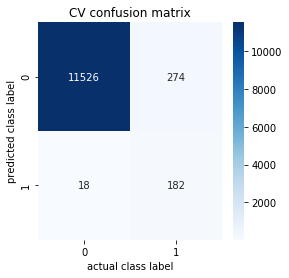

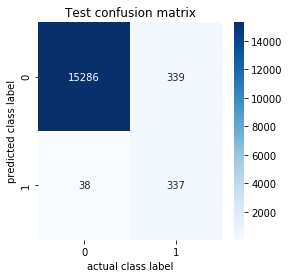

In [22]:
confusion_mat(cm_cv,cm_test)

#### 6.3.6 Custom Ensemble

In [20]:
base_learner = [10,20,25,30,40,50,60]
for i in base_learner:
    custom_model(train=train,cv=cv,test=test,test_also=0,base_learners=i,n_estimators=100)

train macro f1 is  0.9844478376620003 and cv macro f1 is  0.7392233201217626 for no of base learners =  10
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9801476793085588 and cv macro f1 is  0.7304789066261713 for no of base learners =  20
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9815244874804916 and cv macro f1 is  0.7343960715775978 for no of base learners =  25
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9833251846933062 and cv macro f1 is  0.7409454617428839 for no of base learners =  30
---------------------------------------------------------------------------------------------------
train macro f1 is  0.9810790877670214 and cv macro f1 is  0.7312372006807029 for no of base learners =  40
-----------------------------------------------------------------

In [23]:
y_train,y_train_pred,y_cv,y_cv_pred,y_test,y_test_pred = custom_model(train=train,cv=cv,test=test,test_also=1,base_learners=30)

cm_cv = confusion_matrix(y_cv,y_cv_pred)
cm_test = confusion_matrix(y_test,y_test_pred)

total_cost(cm_cv,cm_test)

train macro f1 is  0.9810998367973709 cv macro f1 is  0.7251484246816033 Test macro f1 is  0.7902844941941316 for no of base learners =  30
Total cost on CV data is  190230
Total cost on Test data is  210380


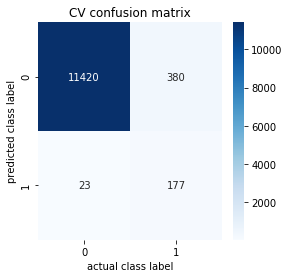

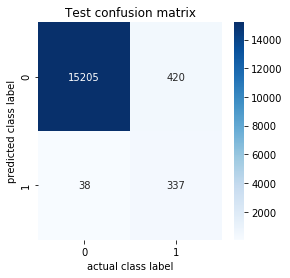

In [24]:
confusion_mat(cm_cv,cm_test)

### Observations

#### 1 - Modelling on unbalanced dataset without Feature engg

In [23]:
pretty1=prettytable.PrettyTable()

pretty1.add_column("model",["SGD with logloss","SGD with log loss","Random Forest","XG Boost","Ada Boost","Custom Model"])
pretty1.add_column("Macro f1 score",["0.84","0.84","0.89","0.91","0.88","0.83"])
pretty1.add_column("Total Cost",["29400","25020","11180","10870","23130","32060"])
pretty1.add_column("False Negative",["56","47","20","20","44","61"])
pretty1.add_column("False Positive",["140","152","118","87","113","151"])

print(pretty1)

+-------------------+----------------+------------+----------------+----------------+
|       model       | Macro f1 score | Total Cost | False Negative | False Positive |
+-------------------+----------------+------------+----------------+----------------+
|  SGD with logloss |      0.84      |   29400    |       56       |      140       |
| SGD with log loss |      0.84      |   25020    |       47       |      152       |
|   Random Forest   |      0.89      |   11180    |       20       |      118       |
|      XG Boost     |      0.91      |   10870    |       20       |       87       |
|     Ada Boost     |      0.88      |   23130    |       44       |      113       |
|    Custom Model   |      0.83      |   32060    |       61       |      151       |
+-------------------+----------------+------------+----------------+----------------+


#### 2 - Modeeling on unbalanced dataset with Feature engg

In [24]:
pretty2=prettytable.PrettyTable()

pretty2.add_column("model",["SGD with logloss","SGD with log loss","Random Forest","XG Boost","Ada Boost","Custom Model"])
pretty2.add_column("Macro f1 score",["0.85","0.85","0.89","0.91","0.87","0.81"])
pretty2.add_column("Total Cost",["34770","25370","10680","8960","22210","28720"])
pretty2.add_column("False Negative",["67","48","19","16","42","54"])
pretty2.add_column("False Positive",["127","137","118","96","121","172"])

print(pretty2)

+-------------------+----------------+------------+----------------+----------------+
|       model       | Macro f1 score | Total Cost | False Negative | False Positive |
+-------------------+----------------+------------+----------------+----------------+
|  SGD with logloss |      0.85      |   34770    |       67       |      127       |
| SGD with log loss |      0.85      |   25370    |       48       |      137       |
|   Random Forest   |      0.89      |   10680    |       19       |      118       |
|      XG Boost     |      0.91      |    8960    |       16       |       96       |
|     Ada Boost     |      0.87      |   22210    |       42       |      121       |
|    Custom Model   |      0.81      |   28720    |       54       |      172       |
+-------------------+----------------+------------+----------------+----------------+


after feature engg there is slight improvement

#### 3 - Modeeling on balanced dataset with Feature engg

In [25]:
pretty3=prettytable.PrettyTable()

pretty3.add_column("model",["SGD with logloss","SGD with log loss","Random Forest","XG Boost","Ada Boost","Custom Model"])
pretty3.add_column("Macro f1 score",["0.79","0.0.8","0.87","0.91","0.81","0.79"])
pretty3.add_column("Total Cost",["205830","190840","11770","37980","169800","210300"])
pretty3.add_column("False Negative",["411","381","33","75","339","420"])
pretty3.add_column("False Positive",["33","34","127","48","38","80"])

print(pretty2)

+-------------------+----------------+------------+----------------+----------------+
|       model       | Macro f1 score | Total Cost | False Negative | False Positive |
+-------------------+----------------+------------+----------------+----------------+
|  SGD with logloss |      0.85      |   34770    |       67       |      127       |
| SGD with log loss |      0.85      |   25370    |       48       |      137       |
|   Random Forest   |      0.89      |   10680    |       19       |      118       |
|      XG Boost     |      0.91      |    8960    |       16       |       96       |
|     Ada Boost     |      0.87      |   22210    |       42       |      121       |
|    Custom Model   |      0.81      |   28720    |       54       |      172       |
+-------------------+----------------+------------+----------------+----------------+


### Conclusion

Best model that we got is XG Boost on actual dataset with Feature Engineering with 0.91 macro f1 score and total cost of 8960

so we will save this model as pickle file for making predictions

In [1]:
clf = XGBClassifier(n_estimators=150, n_jobs=-1,verbosity=0,learning_rate=0.1)
clf.fit(x_train,y_train)

my_model = "model.pkl"
joblib.dump(clf,my_model)

my_model = "model.pkl"
clf = joblib.load(my_model)